# Standard Parameterization (Depreciated)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy.linalg as la

class Model(nn.Module):
    def __init__(self, width):
        super(Model, self).__init__()

        input_size = 10
        layers = [nn.Linear(input_size, width, bias=False), nn.Linear(width,width, bias=False), nn.Linear(width, width, bias=False)]
        
        self.fc_layers = nn.ModuleList(layers)
        self.fc = nn.Linear(width, 1, bias=False)
        
        for m in self.modules():
          if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity = 'relu')

    def forward(self, x):
        for layer in self.fc_layers:
            x = F.relu(layer(x))

        return self.fc(x)

class Pruned_Model(nn.Module):
    def __init__(self, width, mask):
        super(Pruned_Model, self).__init__()

        self.mask = mask
        input_size = 10
        layers = [nn.Linear(input_size, width, bias=False), nn.Linear(width,width, bias=False), nn.Linear(width, width, bias=False)]
        
        self.fc_layers = nn.ModuleList(layers)
        self.fc = nn.Linear(width, 1, bias=False)
        
        for m in self.modules():
          if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity = 'relu')
        self._apply_mask()

    def forward(self, x):
        self._apply_zero_one_mask()
        for layer in self.fc_layers:
            x = F.relu(layer(x))

        return self.fc(x)

    def _apply_mask(self):
        for name, param in self.named_parameters():
            if name in self.mask:
              param.data *= self.mask[name]

    def _apply_zero_one_mask(self):
        for name, param in self.named_parameters():
            if name in self.mask:
              param.data *= self.mask[name] > 0

pruning_fraction = 1/2
width = 5000
model = Model(width)
mask = {}
for name, param in model.named_parameters():
  if name == "fc_layers.0.weight":
    mask[name] = torch.ones(param.shape)
  else:
    mask[name] = torch.from_numpy(np.random.choice([0,1 / np.sqrt(1 - pruning_fraction)], param.shape, p=[pruning_fraction, 1 - pruning_fraction]))

pruned_model = Pruned_Model(width, mask)

np.random.seed(1)
x = np.random.random(10)
x = x / la.norm(x)
x = torch.from_numpy(x).float()
y = np.random.random(10)
y = y / la.norm(y)
y = torch.from_numpy(y).float()

# out_x = model(x)
# out_x.backward()

# estimate = 0
# for m in model.modules():
#   if isinstance(m, nn.Linear):
#     estimate += torch.square(torch.norm(m.weight.grad))
# print(estimate/width)


# pruned_out_x = pruned_model(x)
# pruned_out_x.backward()
# pruned_estimate = 0
# for m in pruned_model.named_modules():
#   if isinstance(m[1], nn.Linear):
#     pruned_estimate += torch.square(torch.norm(m[1].weight.grad * ( mask[m[0] + ".weight"] > 0))) 

# print(pruned_estimate/(width * (1 - pruning_fraction)))
# print(mask)
out_x = model(x)
out_x.backward()

inner_model = 0
grad_model_x = []
for m in model.modules():
  if isinstance(m, nn.Linear):
    grad_model_x.append(torch.clone(m.weight.grad).detach())

model.zero_grad()
out_y = model(y)
out_y.backward()

grad_model_y = []
for m in model.modules():
  if isinstance(m, nn.Linear):
    grad_model_y.append(torch.clone(m.weight.grad).detach())

for i in range(len(grad_model_x)):
  inner_model += torch.sum(grad_model_x[i] * grad_model_y[i])
print(inner_model/width)

pruned_out_x = pruned_model(x)
pruned_out_x.backward()
inner_pruned = 0
grad_pruned_x = []
for m in pruned_model.named_modules():
  if isinstance(m[1], nn.Linear):
    grad_pruned_x.append((torch.clone(m[1].weight.grad).detach() * ( mask[m[0] + ".weight"] > 0))) 

pruned_model.zero_grad()
pruned_out_y = pruned_model(y)
pruned_out_y.backward()
inner_pruned = 0
grad_pruned_y = []
for m in pruned_model.named_modules():
  if isinstance(m[1], nn.Linear):
    grad_pruned_y.append((torch.clone(m[1].weight.grad).detach() * ( mask[m[0] + ".weight"] > 0))) 

for i in range(len(grad_model_x)):
  inner_pruned += torch.sum(grad_pruned_x[i] * grad_pruned_y[i])
print(inner_pruned/(width* (1 - pruning_fraction)))

tensor(0.1977)
tensor(0.1950)


# Compute Theoretical NTK Value

In [ ]:
import numpy as np
import numpy.linalg as la

def t_sigma(rho):
  return (np.sqrt(1 - rho**2) + rho * np.arcsin(rho))/np.pi + rho/2

def t_sigma_dot(rho):
  return 1/2 + np.arcsin(rho) / np.pi

def compute_all_t_sigma(x,y,L):
  # L: the number of hidden layer
  ret = [np.dot(x,y)]
  for i in range(L):
    ret.append(t_sigma(ret[-1]))
  return ret

def compute_all_t_sigma_dot(t_sigmas):
  ret = []
  for t_sigma in t_sigmas[:-1]:
    ret.append(t_sigma_dot(t_sigma))
  ret.append(1)
  return ret

def compute_NTK(x,y,L):
  t_sigmas = compute_all_t_sigma(x,y,L)
  t_sigma_dots = compute_all_t_sigma_dot(t_sigmas)
  ntk = 0
  for i in range(len(t_sigmas)):
    ntk += t_sigmas[i] * np.prod(t_sigma_dots[i:])
  return ntk

np.random.seed(1)
x = np.random.random(10)
x = x / la.norm(x)
y = np.random.random(10)
y = y / la.norm(y)
print(np.inner(x,y))

compute_NTK(x,y,3)

0.7687972123753375


2.4287229440232556

# NTK Parameterization

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy.linalg as la

class Model(nn.Module):
    def __init__(self, width):
        super(Model, self).__init__()

        self.width = width
        input_size = 10
        layers = [nn.Linear(input_size, width, bias=False), nn.Linear(width,width, bias=False), nn.Linear(width, width, bias=False)]
        
        self.fc_layers = nn.ModuleList(layers)
        self.fc = nn.Linear(width, 1, bias=False)
        
        for m in self.modules():
          if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.normal_(m.weight)

    def forward(self, x):
        for layer in self.fc_layers:
            x = torch.sqrt(torch.tensor(2 / self.width)) * F.relu(layer(x))

        return self.fc(x)

class Pruned_Model(nn.Module):
    def __init__(self, width, mask, pruning_fraction):
        super(Pruned_Model, self).__init__()

        self.width = width
        self.mask = mask
        self.pruning_fraction = pruning_fraction
        input_size = 10
        layers = [nn.Linear(input_size, width, bias=False), nn.Linear(width,width, bias=False), nn.Linear(width, width, bias=False)]
        
        self.fc_layers = nn.ModuleList(layers)
        self.fc = nn.Linear(width, 1, bias=False)
        
        for m in self.modules():
          if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.normal_(m.weight)
        self._apply_mask()

    def forward(self, x):
        self._apply_zero_one_mask()
        for layer in self.fc_layers:
            x = torch.sqrt(torch.tensor(2 / (self.width * (1 - self.pruning_fraction)))) * F.relu(layer(x))

        return self.fc(x)

    def _apply_mask(self):
        for name, param in self.named_parameters():
            if name in self.mask:
              param.data *= self.mask[name]

    def _apply_zero_one_mask(self):
        for name, param in self.named_parameters():
            if name in self.mask:
              param.data *= self.mask[name] > 0


In [ ]:
# Initial Trial of Computing Empirical NTK
#establish initial model
pruning_fraction = 1/2
width = 10000
model = Model(width)
mask = {}
for name, param in model.named_parameters():
  if name == "fc_layers.0.weight":
    mask[name] = torch.ones(param.shape)
  else:
    mask[name] = torch.from_numpy(np.random.choice([0,1], param.shape, p=[pruning_fraction, 1 - pruning_fraction]))

pruned_model = Pruned_Model(width, mask, pruning_fraction)

# establish data set
np.random.seed(1)
x = np.random.random(10)
x = x / la.norm(x)
x = torch.from_numpy(x).float()
y = np.random.random(10)
y = y / la.norm(y)
y = torch.from_numpy(y).float()
print(np.inner(x, y))

# compute model grad x
model.zero_grad()
out_x = model(x)
out_x.backward()

inner_model = 0
grad_model_x = []
for m in model.modules():
  if isinstance(m, nn.Linear):
    grad_model_x.append(torch.clone(m.weight.grad).detach())

# compute model grad y
model.zero_grad()
out_y = model(y)
out_y.backward()

grad_model_y = []
for m in model.modules():
  if isinstance(m, nn.Linear):
    grad_model_y.append(torch.clone(m.weight.grad).detach())
# compute ntk of full model
for i in range(len(grad_model_x)):
  inner_model += torch.sum(grad_model_x[i] * grad_model_y[i])
print(inner_model)

# compute pruned model x
pruned_model.zero_grad()
pruned_out_x = pruned_model(x)
pruned_out_x.backward()
inner_pruned = 0
grad_pruned_x = []
for m in pruned_model.named_modules():
  if isinstance(m[1], nn.Linear):
    grad_pruned_x.append((torch.clone(m[1].weight.grad).detach() * ( mask[m[0] + ".weight"] > 0))) 

# compute pruned model y
pruned_model.zero_grad()
pruned_out_y = pruned_model(y)
pruned_out_y.backward()
inner_pruned = 0
grad_pruned_y = []
for m in pruned_model.named_modules():
  if isinstance(m[1], nn.Linear):
    grad_pruned_y.append((torch.clone(m[1].weight.grad).detach() * ( mask[m[0] + ".weight"] > 0))) 

# compute pruned model ntk
for i in range(len(grad_model_x)):
  inner_pruned += torch.sum(grad_pruned_x[i] * grad_pruned_y[i])
print(inner_pruned)

In [ ]:
# Study Width and Empirical NTK
exponents = list(range(5,14))
sample = 64

# establish data set
np.random.seed(1)
x = np.random.random(10)
x = x / la.norm(x)
x = torch.from_numpy(x).float()
y = np.random.random(10)
y = y / la.norm(y)
y = torch.from_numpy(y).float()
print(np.inner(x, y))

width_model_inners = []
width_pruned_inners = []

for exponent in exponents:
  width = 2**exponent

  model_inners = []
  pruned_inners = []
  for i in range(sample):
    #establish initial model
    pruning_fraction = 1/2
    model = Model(width)

    mask = {}
    for name, param in model.named_parameters():
      if name == "fc_layers.0.weight":
        mask[name] = torch.ones(param.shape)
      else:
        mask[name] = torch.from_numpy(np.random.choice([0,1], param.shape, p=[pruning_fraction, 1 - pruning_fraction]))

    pruned_model = Pruned_Model(width, mask, pruning_fraction)

    # compute model grad x
    model.zero_grad()
    out_x = model(x)
    out_x.backward()

    inner_model = 0
    grad_model_x = []
    for m in model.modules():
      if isinstance(m, nn.Linear):
        grad_model_x.append(torch.clone(m.weight.grad).detach())

    # compute model grad y
    model.zero_grad()
    out_y = model(y)
    out_y.backward()

    grad_model_y = []
    for m in model.modules():
      if isinstance(m, nn.Linear):
        grad_model_y.append(torch.clone(m.weight.grad).detach())
    # compute ntk of full model
    for i in range(len(grad_model_x)):
      inner_model += torch.sum(grad_model_x[i] * grad_model_y[i])
    model_inners.append(inner_model)

    # compute pruned model x
    pruned_model.zero_grad()
    pruned_out_x = pruned_model(x)
    pruned_out_x.backward()
    inner_pruned = 0
    grad_pruned_x = []
    for m in pruned_model.named_modules():
      if isinstance(m[1], nn.Linear):
        grad_pruned_x.append((torch.clone(m[1].weight.grad).detach() * ( mask[m[0] + ".weight"] > 0))) 

    # compute pruned model y
    pruned_model.zero_grad()
    pruned_out_y = pruned_model(y)
    pruned_out_y.backward()
    grad_pruned_y = []
    for m in pruned_model.named_modules():
      if isinstance(m[1], nn.Linear):
        grad_pruned_y.append((torch.clone(m[1].weight.grad).detach() * ( mask[m[0] + ".weight"] > 0))) 

    # compute pruned model ntk
    for i in range(len(grad_pruned_x)):
      inner_pruned += torch.sum(grad_pruned_x[i] * grad_pruned_y[i])
    pruned_inners.append(inner_pruned)
  width_model_inners.append(model_inners)
  width_pruned_inners.append(pruned_inners)

width_model_inners = np.array(width_model_inners)
width_pruned_inners = np.array(width_pruned_inners)
np.save("width_model_inners", width_model_inners)
np.save("width_pruned_inners", width_pruned_inners)

0.7687972


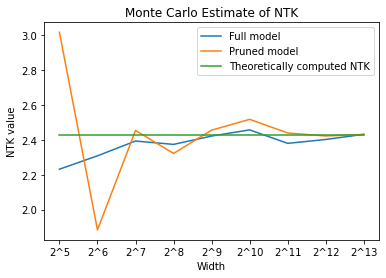

In [ ]:
import matplotlib.pyplot as plt

plt.plot([f"2^{i:.0f}" for i in exponents], np.mean(width_model_inners, axis=1), label="Full model")
plt.plot([f"2^{i:.0f}" for i in exponents], np.mean(width_pruned_inners, axis=1), label="Pruned model")
plt.plot([f"2^{i:.0f}" for i in exponents], [2.4287229440232556 for i in exponents], label="Theoretically computed NTK")
plt.title("Monte Carlo Estimate of NTK")
plt.xlabel("Width")
plt.ylabel("NTK value")
plt.legend()
plt.savefig("sample_estimate_of_ntk.pdf")

In [ ]:
pruning_fractions = [i / 8 for i in range(8)]
sample = 100

# establish data set
x = np.load("x.npy")
x = torch.from_numpy(x).float()
y = np.load("y.npy")
y = torch.from_numpy(y).float()
print(np.inner(x, y))

fraction_pruned_inners = []


for pruning_fraction in pruning_fractions:
  width = int(2**10 / np.sqrt(1 - pruning_fraction))
  pruned_inners = []
  for i in range(sample):
    #establish initial model
    
    model = Model(width)

    mask = {}
    for name, param in model.named_parameters():
      if name == "fc_layers.0.weight":
        mask[name] = torch.ones(param.shape)
      else:
        mask[name] = torch.from_numpy(np.random.choice([0,1], param.shape, p=[pruning_fraction, 1 - pruning_fraction]))

    pruned_model = Pruned_Model(width, mask, pruning_fraction)

    # compute pruned model x
    pruned_model.zero_grad()
    pruned_out_x = pruned_model(x)
    pruned_out_x.backward()
    inner_pruned = 0
    grad_pruned_x = []
    for m in pruned_model.named_modules():
      if isinstance(m[1], nn.Linear):
        grad_pruned_x.append((torch.clone(m[1].weight.grad).detach() * ( mask[m[0] + ".weight"] > 0))) 

    # compute pruned model y
    pruned_model.zero_grad()
    pruned_out_y = pruned_model(y)
    pruned_out_y.backward()
    grad_pruned_y = []
    for m in pruned_model.named_modules():
      if isinstance(m[1], nn.Linear):
        grad_pruned_y.append((torch.clone(m[1].weight.grad).detach() * ( mask[m[0] + ".weight"] > 0))) 

    # compute pruned model ntk
    for i in range(len(grad_pruned_x)):
      inner_pruned += torch.sum(grad_pruned_x[i] * grad_pruned_y[i])
    pruned_inners.append(inner_pruned)
  fraction_pruned_inners.append(pruned_inners)

fraction_pruned_inners = np.array(fraction_pruned_inners)
np.save("fraction_pruned_inners_sqrt_scale_width", fraction_pruned_inners)

0.7687972


In [ ]:
print(np.mean(np.absolute(fraction_pruned_inners - 2.4287229440232556), axis=1))
print(np.var(fraction_pruned_inners, axis=1))
# print(fraction_pruned_inners)

[0.23513708 0.23115231 0.23681591 0.2537792  0.22512259 0.26605535
 0.2790307  0.35046417 0.35993114 0.48605943]
[0.08243147 0.08672915 0.08745161 0.09382075 0.08692919 0.10298052
 0.11704929 0.18571487 0.20634703 0.35487553]


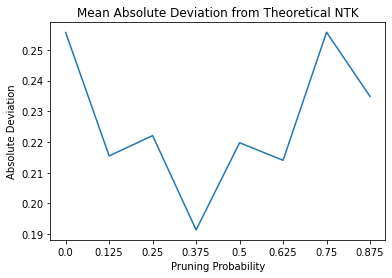

In [ ]:
import matplotlib.pyplot as plt

plt.plot([str(pruning_fraction) for pruning_fraction in pruning_fractions], np.mean(np.absolute(fraction_pruned_inners - 2.4287229440232556), axis=1))

plt.title("Mean Absolute Deviation from Theoretical NTK")
plt.xlabel("Pruning Probability")
plt.ylabel("Absolute Deviation")
plt.savefig("mean_deviation_sqrt_scale_width.png")
plt.savefig("mean_deviation_sqrt_scale_width.pdf")

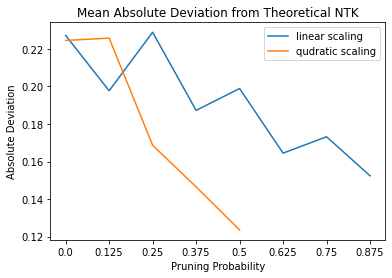

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fraction_pruned_inners_linear = np.load("fraction_pruned_inners_linear_scale_width.npy")
fraction_pruned_inners_quadratic = np.load("fraction_pruned_inners_quadratic_scale_width.npy")

pruning_fractions = [i / 8 for i in range(8)]
plt.plot([str(pruning_fraction) for pruning_fraction in pruning_fractions], np.mean(np.absolute(fraction_pruned_inners_linear - 2.4287229440232556), axis=1), label="linear scaling")
plt.plot([str(pruning_fraction) for pruning_fraction in pruning_fractions][:5], np.mean(np.absolute(fraction_pruned_inners_quadratic - 2.4287229440232556), axis=1), label="qudratic scaling")

plt.title("Mean Absolute Deviation from Theoretical NTK")
plt.xlabel("Pruning Probability")
plt.ylabel("Absolute Deviation")
plt.legend()
plt.savefig("mean_deviation_linear_quadratic_scale_width.png")
plt.savefig("mean_deviation_linear_quadratic_scale_width.pdf")

# Empirical NTK with Pruning the Input Layer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy.linalg as la

class Model(nn.Module):
    def __init__(self, width):
        super(Model, self).__init__()

        self.width = width
        input_size = 10
        layers = [nn.Linear(input_size, width, bias=False), nn.Linear(width,width, bias=False), nn.Linear(width, width, bias=False)]
        
        self.fc_layers = nn.ModuleList(layers)
        self.fc = nn.Linear(width, 1, bias=False)
        
        for m in self.modules():
          if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.normal_(m.weight)

    def forward(self, x):
        for layer in self.fc_layers:
            x = torch.sqrt(torch.tensor(2 / self.width)) * F.relu(layer(x))

        return self.fc(x)

class Pruned_Model(nn.Module):
    def __init__(self, width, mask, pruning_fraction):
        super(Pruned_Model, self).__init__()

        self.width = width
        self.mask = mask
        self.pruning_fraction = pruning_fraction
        input_size = 10
        layers = [nn.Linear(input_size, width, bias=False), nn.Linear(width,width, bias=False), nn.Linear(width, width, bias=False)]
        
        self.fc_layers = nn.ModuleList(layers)
        self.fc = nn.Linear(width, 1, bias=False)
        
        for m in self.modules():
          if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.normal_(m.weight)
        self._apply_mask()

    def forward(self, x):
        self._apply_zero_one_mask()
        for layer in self.fc_layers:
            x = torch.sqrt(torch.tensor(2 / (self.width * (1 - self.pruning_fraction)))) * F.relu(layer(x))

        return torch.sqrt(torch.tensor(1 / (1 - self.pruning_fraction))) * self.fc(x)

    def _apply_mask(self):
        for name, param in self.named_parameters():
            if name in self.mask:
              param.data *= self.mask[name]

    def _apply_zero_one_mask(self):
        for name, param in self.named_parameters():
            if name in self.mask:
              param.data *= self.mask[name] > 0


In [ ]:
# Study Width and Empirical NTK
exponents = list(range(5,14))
sample = 64

# establish data set
np.random.seed(1)
x = np.random.randn(10)
x = x / la.norm(x)
x = torch.from_numpy(x).float()
y = np.random.randn(10)
y = y / la.norm(y)
y = torch.from_numpy(y).float()
print(np.inner(x, y))

width_model_inners = []
width_pruned_inners = []

for exponent in exponents:
  width = 2**exponent

  model_inners = []
  pruned_inners = []
  for i in range(sample):
    #establish initial model
    pruning_fraction = 1/2
    model = Model(width)

    mask = {}
    for name, param in model.named_parameters():
      mask[name] = torch.from_numpy(np.random.choice([0,1], param.shape, p=[pruning_fraction, 1 - pruning_fraction]))

    pruned_model = Pruned_Model(width, mask, pruning_fraction)

    # compute model grad x
    model.zero_grad()
    out_x = model(x)
    out_x.backward()

    inner_model = 0
    grad_model_x = []
    for m in model.modules():
      if isinstance(m, nn.Linear):
        grad_model_x.append(torch.clone(m.weight.grad).detach())

    # compute model grad y
    model.zero_grad()
    out_y = model(y)
    out_y.backward()

    grad_model_y = []
    for m in model.modules():
      if isinstance(m, nn.Linear):
        grad_model_y.append(torch.clone(m.weight.grad).detach())
    # compute ntk of full model
    for i in range(len(grad_model_x)):
      inner_model += torch.sum(grad_model_x[i] * grad_model_y[i])
    model_inners.append(inner_model)

    # compute pruned model x
    pruned_model.zero_grad()
    pruned_out_x = pruned_model(x)
    pruned_out_x.backward()
    inner_pruned = 0
    grad_pruned_x = []
    for m in pruned_model.named_modules():
      if isinstance(m[1], nn.Linear):
        grad_pruned_x.append((torch.clone(m[1].weight.grad).detach() * ( mask[m[0] + ".weight"] > 0))) 

    # compute pruned model y
    pruned_model.zero_grad()
    pruned_out_y = pruned_model(y)
    pruned_out_y.backward()
    grad_pruned_y = []
    for m in pruned_model.named_modules():
      if isinstance(m[1], nn.Linear):
        grad_pruned_y.append((torch.clone(m[1].weight.grad).detach() * ( mask[m[0] + ".weight"] > 0))) 

    # compute pruned model ntk
    for i in range(len(grad_pruned_x)):
      inner_pruned += torch.sum(grad_pruned_x[i] * grad_pruned_y[i])
    pruned_inners.append(inner_pruned)
  width_model_inners.append(model_inners)
  width_pruned_inners.append(pruned_inners)

width_model_inners = np.array(width_model_inners)
width_pruned_inners = np.array(width_pruned_inners)
np.save("width_model_inners", width_model_inners)
np.save("width_all_pruned_inners", width_pruned_inners)

0.9999999999999999
1.0
0.7687972


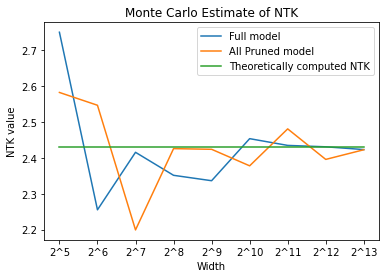

In [ ]:
import matplotlib.pyplot as plt

plt.plot([f"2^{i:.0f}" for i in exponents], np.mean(width_model_inners, axis=1), label="Full model")
plt.plot([f"2^{i:.0f}" for i in exponents], np.mean(width_pruned_inners, axis=1), label="All Pruned model")
plt.plot([f"2^{i:.0f}" for i in exponents], [2.4287229440232556 for i in exponents], label="Theoretically computed NTK")
plt.title("Monte Carlo Estimate of NTK")
plt.xlabel("Width")
plt.ylabel("NTK value")
plt.legend()
# plt.savefig("sample_estimate_of_ntk_all_pruned.pdf")